# Epidemic Models on Networks
In this section we consider a special kind of continuous time Markov chain, as presented in Lab04, which is used to simulate the spread of epidemics over a network.

### Theory recap: Pairwise interacting network systems

Consider a finite population of agents, identified with the nodes of a graph $\mathcal G = (\mathcal V, \mathcal E, W)$. 
Each agent $i \in \mathcal V$ has a state $x_i \in \mathcal A$ and all states are collected in the configuration vector $x \in \mathcal X = \mathcal A^{\mathcal V}$.

We consider an **evolution process** for the state vector $X(t)$ which is _caused by pairwise interactions between neighbouring nodes in the graph and by spontaneous mutation_.
- Each node is equipped with a Poisson clock with rate $1$. When the clock ticks, the agent is activated and it undergoes a **spontaneous mutation**.The probabilities of spontaneous mutations (conditional on the ticking of the clock) are described by the **mutation kernels**
	$$
	\psi^{(i)}\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad  i\in\mathcal V
	$$
- Each directed link has a Poisson clock with rate $\beta W_{ij}$. When the clock ticks, the link is activated, agent $i$ meets agent $j$ and as a consequence $i$ makes a **transition**.  The transition probabilities (conditional on the ticking of the clock) are described by the **pairwise interaction kernels**
	$$
	\varphi^{(i,j)}(c)\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad (i,j)\in\mathcal E\,,\qquad c\in\mathcal A
	$$
    
Then, pairwise interacting network systems are **continuous time Markov chains** with state space $\mathcal X = \mathcal A^{\mathcal V}$ and transition rates
$$
\Lambda_{x,y}=\begin{cases}
\psi^{(i)}_{x_i,y_i}+\beta\sum_jW_{ij}\varphi_{x_iy_i}^{(i,j)}(x_j) \quad \text{  if  } x_i\ne y_i\text{ and }x_{-i}=y_{-i}\\
0 \quad \text{  if  } x\text{ and }y\text{ differ in more than }1\text{ element}\,,
\end{cases}$$


The main models you studied during the lectures are:
$$\textbf{SI:}\qquad\psi=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIS:}\qquad\psi=\left[\begin{array}{cc}1&0\\1&0\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIR:}\qquad\psi=\left[\begin{array}{ccc}1&0&0\\0&0&1\\0&0&1\end{array}\right]\qquad\varphi(S)=\varphi(R)=\left[\begin{array}{ccc}1&0&0\\0&1&0\\0&0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{ccc}0&1&0\\0&1&0\\0&0&1\end{array}\right]$$

## SI model
The SI model is a pairwise interacting network system characterized by the following interaction kernels:
$$
\phi(0) = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \quad
\phi(1) = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix}
$$

In the SI model, each node can be either in a susceptible (denoted S or 0) or infected (denoted I or 1) state. When a susceptible node makes contact with an infected one, the contagion spreads and the susceptible node becomes infected.

### Example: SI model on a grid
In this example we consider the SI model on a $3 \times 3$ grid. We simulate the evolution of the epidemics starting from a configuration where only one node is infected and all the rest are susceptible.

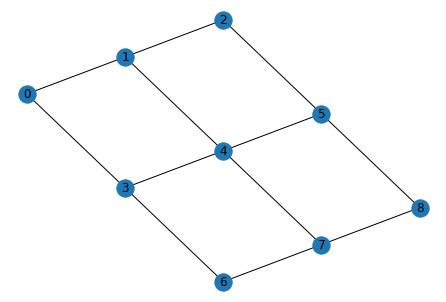

In [1]:
# Construct the graph describing interactions among agents

import networkx as nx

size = 3
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = dict()
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G, with_labels=True)

In [2]:
# Define the Markov chain by constructing its transition matrix Lambda

import numpy as np
import scipy as sp

# Number of agents
n_agents = len(G)

# Pairwise interaction kernels
phi = np.array([[[1,0],
                 [0,1]], 
                [[0,1],
                 [0,1]]])
# Links activation rate 
beta = 1

# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

# Initialize transition rates matrix
n_config = 2**n_agents
Lambda = sp.sparse.lil_matrix((n_config,n_config))

# Number of states for each agent
n_states =tuple(2 for _ in range(len(G)))

# Fill transition rates matrix
# For each configuration x, we consider all configurations y that differ only
# in the state of a single agent and we compute the rate for the admissble 
# transition x->y
for x_id in range(n_config):
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for agent in range(n_agents):
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        for other_agent in range(n_agents):
            Lambda[x_id, y_id] += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]


In [3]:
# Simulate the evolution of the epidemics

# Simulate the Markov chain with local clocks method
w = np.sum(Lambda, axis=1)
w = np.array(w.T)[0]
for x, weight in enumerate(w):
    if weight == 0:
        Lambda[x,x] = 1
        w[x] = 1
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

n_steps = 12

# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]

P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    states[i] = np.argwhere(P_cum[states[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

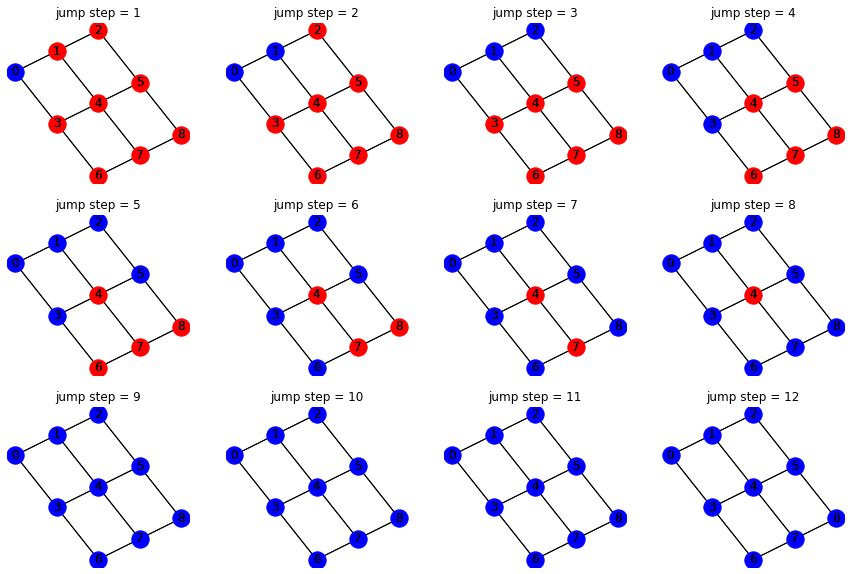

In [4]:
# Plot the infection spread

import matplotlib.pyplot as plt

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

**Remark**: we simulated the evolution of the epidemics by exploiting the general simulation method for continuous time Markov chains viewd in Lab04. This is totally correct, and it is the easiest way to understand and learn the process, but it requires **precomputing the transition matrix** Lambda, which is then used to perform the simulation. Computing the whole Lambda has a large computational cost, and it becomes practically unfeasable when the number of agents grows. To have a better idea, try to repeat the previous simulation on a $4 \times 4$ or $5 \times 5$ grid, and see how the computational time blows up.

To overcome this issue, a more efficient simulation method is proposed below, which may turn usefull if you need to deal with larger models. Instead of precomputing the transition matrix Lambda, it computes its rows along the way when needed. In particular, when the process is at some configuration $x$, row $x$ of $\Lambda$ is computed, used to compute the probabilities of transitions from $x$ and to pick the next visited configuration.

Try again to simulate the SI model on a $4 \times 4$ grid with this method to appreciate the computational saving.

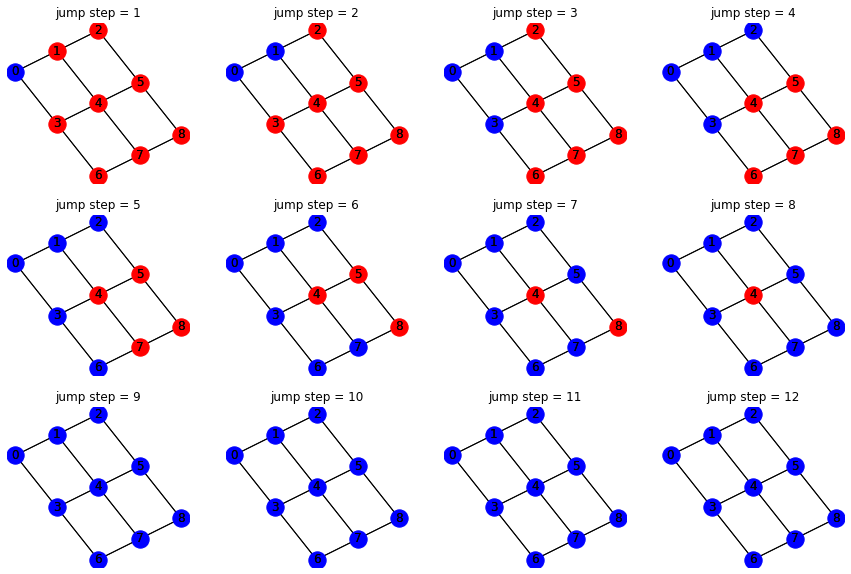

In [5]:
# Simulation with local clocks method
# In this variant, the matrix Lambda is not precomputed

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissble destination and append it to the list
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        rate = 0
        for other_agent in range(n_agents):
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
        
# Plot the infection spread
pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

### Exercise
Simulate other epidemic models, like the SIS and SIR.

In [6]:
# TO DO

# Random graphs as a model for a citation network
The real world network in this problem is a citation network with 10000 papers. It can be loaded with the following code

In [7]:
import scipy.io as sio
import networkx as nx
import numpy as np
import scipy as sp
import collections 
import matplotlib.pyplot as plt

citation = sio.loadmat('citation1.mat', variable_names=['citation'])
citation = citation['citation']

This is a directed network where each node represents a paper and a link from node i to j means that paper i cited paper j. The variable `citation` is an array with 3 columns. Each row contains the tail and head node of a link and the weight associated to such link in the adjacency matrix of the graph (in this case, the weight is either 1 or 0). The graph is constructed from the `citation` variable as follows:

In [8]:
G = nx.DiGraph()
for i,j,w in citation:
    if w != 0:
        G.add_edge(i,j)

n_nodes_cit = nx.classes.function.number_of_nodes(G)
n_links_cit = nx.classes.function.number_of_edges(G)

In the following, we analyze how to approximate the citation graph with different random graph models. We then compare the obtained approximations to see which one is the best for this example.

## Erdos-Renyi-model
To approximate the citation network we construct an Erdos-Renyi-model with as many nodes as the real network, that is n. Remember that the expected number of links in such model is $\binom{n}{2}p$ where $p$ is the probability of there being a link between any two distinct nodes i and j. We chose p such that the expected number of links is the same as the number of links in the actual citation network. By construction, this random graph will not have any self loop.


In [9]:
# Construction of the Erdos-Renyi model

# chose p so that the expected number of links is the same as n_links_cit
# factor 2 at denominator is because G is directed
p = n_links_cit/(sp.special.binom(n_nodes_cit,2) * 2) 
# add links between couple of different nodes with probability p
WER = np.random.choice([0,1], size=(n_nodes_cit, n_nodes_cit), p= [1-p,p])
# GER has no self loops
for n in range(n_nodes_cit):
    WER[n,n] = 0
    
GER = nx.from_numpy_array(WER, create_using=nx.DiGraph)

## The configuration model 
Here we construct a configuration model to approximate the citation network. To do this, we proceed as follows: given the in and out-degree of the real network, we pick uniformly at random one out-link and one in-link and connect them.

In [10]:
# Construction of the Configuration model

WCM = np.zeros((n_nodes_cit, n_nodes_cit))
residual_out_degree = np.array(list(degree for node, degree in G.out_degree()))
residual_in_degree = np.array(list(degree for node, degree in G.in_degree()))

# for each node
for i in range(n_nodes_cit):
    # while there are unconnected out "half links"
    while residual_out_degree[i] > 0:
        available_targets = np.arange(n_nodes_cit)
        # a target is available if its residual in degree is positive
        available_targets= available_targets[np.argwhere(residual_in_degree > 0)].flatten()
        # randomly connect the link to the targets
        target = np.random.choice(available_targets)
        WCM[i,target] = 1
        # decrease out/in degree of the connected nodes
        residual_in_degree[target] -=1
        residual_out_degree[i] -=1


GCM = nx.from_numpy_array(WCM, create_using=nx.DiGraph)

## Preferential attachment model
The preferential attachment is a model for growing random graphs which was explicitly introduced to model citation networks. We now explore this model to see if it is capable of approximating the real citation network.

We generate a random graph by the preferential attachment model, so that the final number of nodes n is the same as in the real citation network and so that the degree distrubution is similar. To do this, we start with directed graph $G_0$ containing 2  nodes connected to each other.
At timestep $t$ $(t\geq1)$, we add a new node to the graph and connect it to $c$ other nodes already present in $G_{t}$, the resulting graph is called $G_{t+1}$. The value of $c$ is chosen randomly with probabilities according to the out-degree distribution of the real citation network. For each of the $c$ new connections, the destination node is chosen with probability proportional to the in-degree distribution of $G_{t}$ plus a constant $a$ , so that the probability that node $i$ is chosen is given by
$$
p_i(t)=\frac{w_i^-(t) + a}{\sum_j (w_j^-(t)+a)}.
$$
When $a \neq 0$, each node has an intrinsic probability of being selected as a neighbor from new nodes, regardless of its in-degree.
The process stops when the total number of nodes $n$ is reached.

In [11]:
# Preferential attachment
GPA = nx.DiGraph()
# GPA is initialized to G0, containing two nodes connected to each other
GPA.add_edges_from([(0,1),(1,0)])

# compute out degree distribution of real citation graph

# degree sequence contains the out degree of nodes ordered from larger
# to smaller
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True) 
# count for each out-degree value, how many nodes have that out-degree
# degreeCount is a list of tuples (degree value, number of nodes)
degreeCount = collections.Counter(degree_sequence)
# zip() returns an iterator of tuples where the first item in each passed tuple 
# is paired together, the second item in each passed tuple are paired together
# and so on.
# In this way we obtain deg, which is the tuple of degree values, and
# cnt which is the tuple of the counts.
deg, cnt = zip(*degreeCount.items())
deg_distr = np.array(cnt)/sum(cnt)

# set a, the intrinsic probability of a node to be selected as a neighbor 
# from new nodes
a = 1 

# add the remaining nodes one at a time
for node in range(2,n_nodes_cit):
    # compute degree of new node according to deg_distr (degree distribution
    # of the real citation graph).
    # the min guarantees that the new node is not assigned a degree
    # larger than the current size of GPA
    degree = min(np.random.choice(deg,p=deg_distr), len(GPA)) 
    # choose `degree` neighbors for node to connect to according to their 
    # in-degree in the current approximation GPA.
    # compute updated in degree sequence
    in_deg_PA = [d for n, d in GPA.in_degree()] 
    # add a so that also node with 0 in-degree have non-zero probability
    # of being chosen
    in_deg_PA = np.array(in_deg_PA)+a 
    # normalize to obtain a probability distribution
    in_deg_PA = in_deg_PA/sum(in_deg_PA)
    # replace=False guarantees no neighbor is chosen twice
    neighbors = np.random.choice(np.arange(len(GPA)), p=in_deg_PA, size=degree, replace=False)
    # add the new node (new node is added even if its out-degree is zero)
    GPA.add_node(node)
    # add the new links 
    for neigh in neighbors:
        GPA.add_edge(node,neigh) 
       

## Comparing models
We use the following measures to investigate how the Erdos-Renyi-model, Configuration Model and Preferntial Attachment model are able to approximate the real citation network.
1. Diameter 
2. Average distance between nodes
3. Degree distribution

**Remark:** since the network is not strongly connected, with the usual computation the Diameter becomes infinity. To get a more meaningful result, one can get this diameter as the maximum diameter of each connected component. A similar argument applies to the average distance between nodes.

In [12]:
# Diameter
length_dict = dict(nx.all_pairs_shortest_path_length(G))
lengths = [lenght for d in length_dict.values() for lenght in d.values()]
diameter = max(lengths)
print("Diameter:", diameter)

length_dict_ER = dict(nx.all_pairs_shortest_path_length(GER))
lengths_ER = [lenght for d in length_dict_ER.values() for lenght in d.values()]
diameter_ER = max(lengths_ER)
print("Diameter ER:", diameter_ER)

length_dict_CM = dict(nx.all_pairs_shortest_path_length(GCM))
lengths_CM = [lenght for d in length_dict_CM.values() for lenght in d.values()]
diameter_CM = max(lengths_CM)
print("Diameter CM:", diameter_CM)

length_dict_PA = dict(nx.all_pairs_shortest_path_length(GPA))
lengths_PA = [lenght for d in length_dict_PA.values() for lenght in d.values()]
diameter_PA = max(lengths_PA)
print("Diameter PA:", diameter_PA)

Diameter: 10
Diameter ER: 27
Diameter CM: 28
Diameter PA: 9


In [13]:
# Average distance

ad = np.average(lengths)
print("Average distance:",ad)
ad_ER = np.average(lengths_ER)
print("Average distance ER:",ad_ER)
ad_CM = np.average(lengths_CM)
print("Average distance CM:",ad_CM)
ad_PA = np.average(lengths_PA)
print("Average distance PA:",ad_PA)


Average distance: 2.6242914979757086
Average distance ER: 11.01228146878949
Average distance CM: 10.06914742662541
Average distance PA: 2.0900760066842756


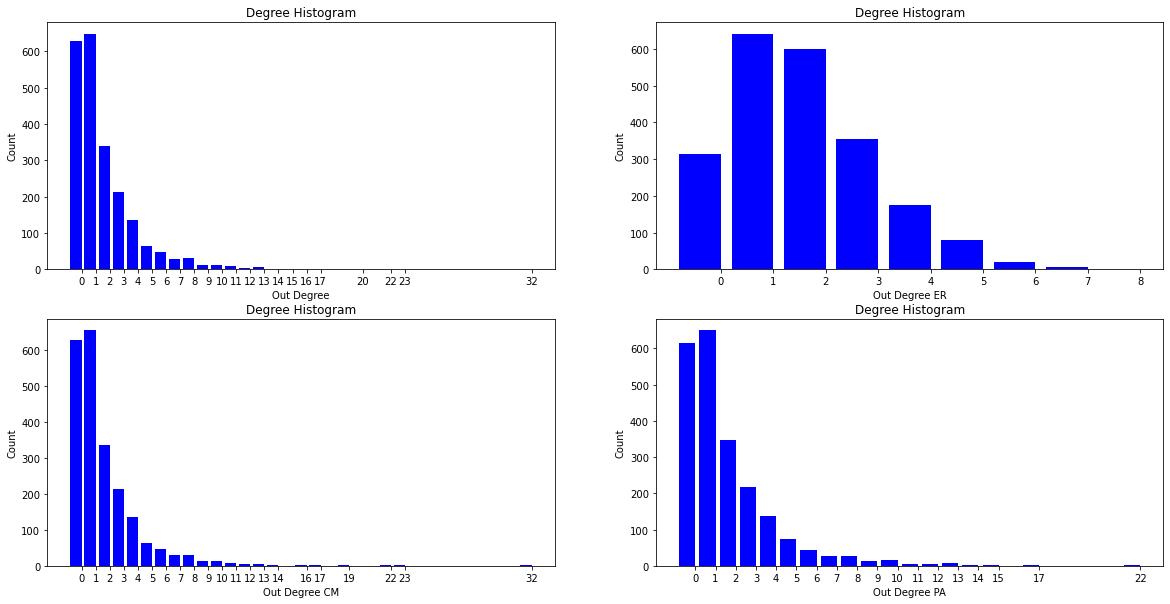

In [14]:
# out-degree

import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True) 
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_sequence_ER = sorted([d for n, d in GER.out_degree()], reverse=True)  # degree sequence
degreeCount_ER = collections.Counter(degree_sequence_ER)
deg_ER, cnt_ER = zip(*degreeCount_ER.items())

degree_sequence_CM = sorted([d for n, d in GCM.out_degree()], reverse=True)  # degree sequence
degreeCount_CM = collections.Counter(degree_sequence_CM)
deg_CM, cnt_CM = zip(*degreeCount_CM.items())

degree_sequence_PA = sorted([d for n, d in GPA.out_degree()], reverse=True)  # degree sequence
degreeCount_PA = collections.Counter(degree_sequence_PA)
deg_PA, cnt_PA = zip(*degreeCount_PA.items())

plt.figure(figsize=[20, 10])

ax = plt.subplot(2,2,1)
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Out Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

ax = plt.subplot(2,2,2)
plt.bar(deg_ER, cnt_ER, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Out Degree ER")
ax.set_xticks([d + 0.4 for d in deg_ER])
ax.set_xticklabels(deg_ER);

ax = plt.subplot(2,2,3)
plt.bar(deg_CM, cnt_CM, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Out Degree CM")
ax.set_xticks([d + 0.4 for d in deg_CM])
ax.set_xticklabels(deg_CM);

ax = plt.subplot(2,2,4)
plt.bar(deg_PA, cnt_PA, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Out Degree PA")
ax.set_xticks([d + 0.4 for d in deg_PA])
ax.set_xticklabels(deg_PA);

**Remark**: Degrees of the real network and of the CM approximation coincide, since the CM model is such that the resulting graph has a prescribed degree distribution.

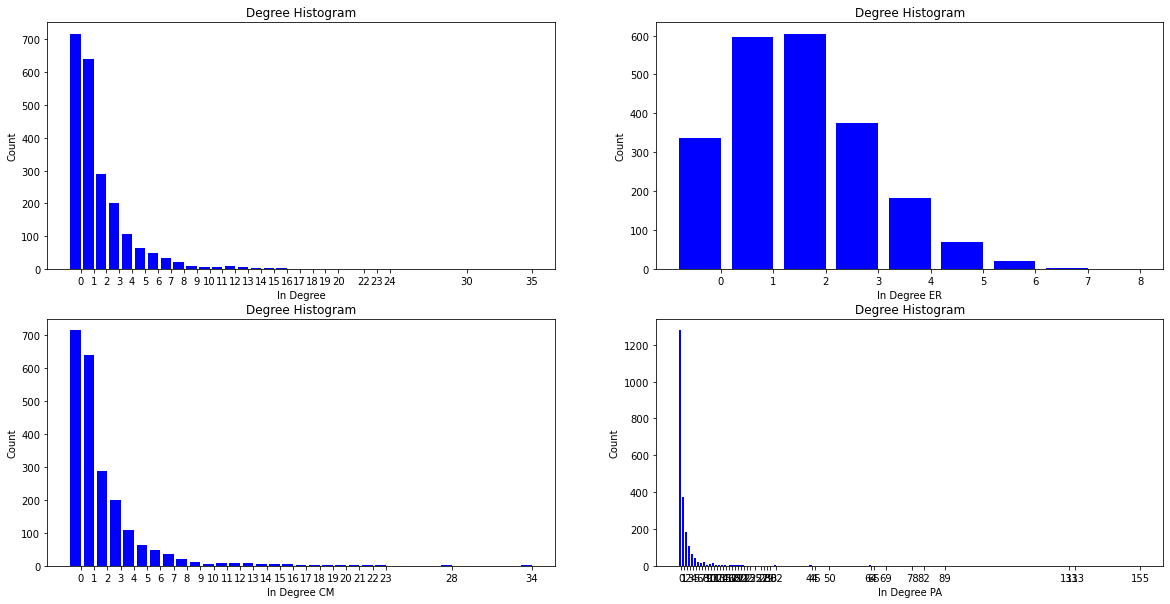

In [15]:
# in-degree

degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_sequence_ER = sorted([d for n, d in GER.in_degree()], reverse=True)  # degree sequence
degreeCount_ER = collections.Counter(degree_sequence_ER)
deg_ER, cnt_ER = zip(*degreeCount_ER.items())

degree_sequence_CM = sorted([d for n, d in GCM.in_degree()], reverse=True)  # degree sequence
degreeCount_CM = collections.Counter(degree_sequence_CM)
deg_CM, cnt_CM = zip(*degreeCount_CM.items())

degree_sequence_PA = sorted([d for n, d in GPA.in_degree()], reverse=True)  # degree sequence
degreeCount_PA = collections.Counter(degree_sequence_PA)
deg_PA, cnt_PA = zip(*degreeCount_PA.items())

plt.figure(figsize=[20, 10])

ax = plt.subplot(2,2,1)
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

ax = plt.subplot(2,2,2)
plt.bar(deg_ER, cnt_ER, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree ER")
ax.set_xticks([d + 0.4 for d in deg_ER])
ax.set_xticklabels(deg_ER);

ax = plt.subplot(2,2,3)
plt.bar(deg_CM, cnt_CM, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree CM")
ax.set_xticks([d + 0.4 for d in deg_CM])
ax.set_xticklabels(deg_CM);

ax = plt.subplot(2,2,4)
plt.bar(deg_PA, cnt_PA, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree PA")
ax.set_xticks([d + 0.4 for d in deg_PA])
ax.set_xticklabels(deg_PA);

**Remaek**: The in-degree distribution of the PA approximation presents a few nodes with very high in-degree (over 100) and large portion of nodes (the majority) having degree 0. If we exclude both extreme values, the rest of the PA degree distribution is an accurate approximation of the real one, as the following picture illustrates:

(0.0, 750.75)

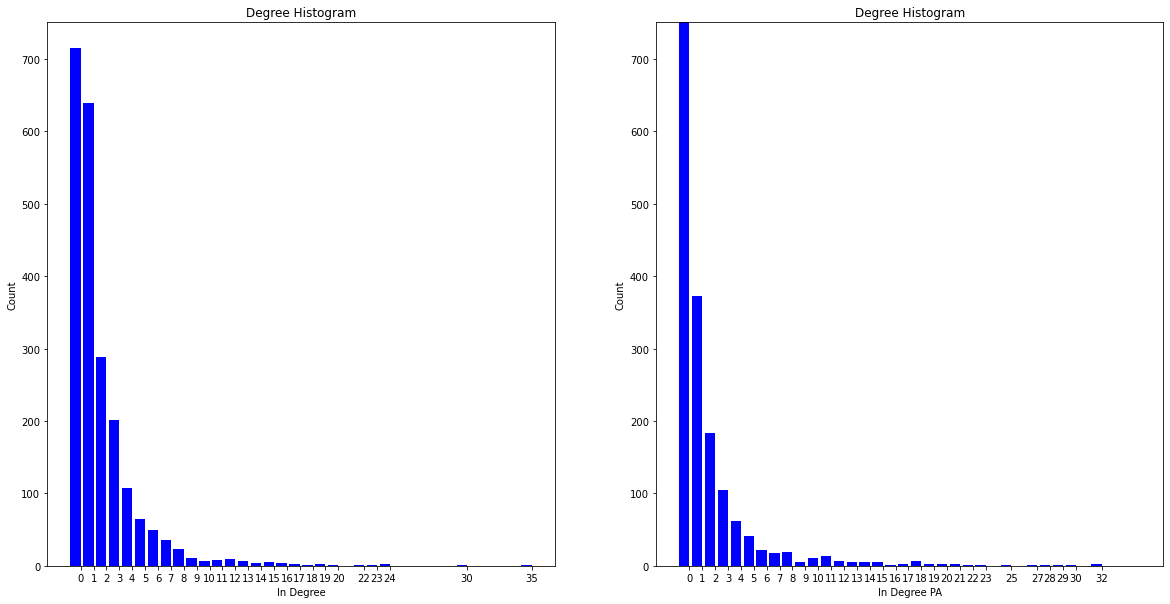

In [16]:
plt.figure(figsize=[20, 10])

# in degree of real network
ax = plt.subplot(1,2,1)
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

# we extract the x and y ranges from the real network diagram
# in order to represent only the non-extremal portion of the PA histogram
xleft, xright = plt.xlim()  # return the current xlim
yleft, yright = plt.ylim()  # return the current ylim
  
ax = plt.subplot(1,2,2)
plt.bar(deg_PA, cnt_PA, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree PA")
ax.set_xticks([d + 0.4 for d in deg_PA])
ax.set_xticklabels(deg_PA);
plt.xlim(xleft, xright)   # set the xlim 
plt.ylim(yleft, yright)   # set the ylim 

### Exercise
Try to tune the a parameter in the PA model (the intrinsic probability of a node to be selected as a neighbor from new nodes, regardless of its in-degree) to obtain a better approximation of the real in-degree distribution.

In [17]:
# TO DO

## Conclusion
The results give an experimental verification of how the preferential attachment model is best suited to approximate citation networks. Indeed, it reaches the best approximation results with respect to all the analyzed measures (for the degree distributions the previous remarks hold).